# Dynamic Programming and Structural Econometrics #5

### Function approximation and interpolation

**Readings:** 
- 📖 Judd, K. L. (1998). Numerical methods in economics. MIT press. Section 7.1-7.5, 8.2
- 📖 Jerome Adda and Russell Cooper “Dynamic Economics. Quantitative Methods and Applications.” Sections 3.5 

by Bertel Schjerning

University of Copenhagen


### Approximation problem

- $ f(x) $ is function of interest, hard to compute  
- Have data on values of $ f(x) $ in $ n $ points
  $ (x_1,\dots,x_n) $  


$$
f(x_1), f(x_2), \dots f(x_n)
$$

- Need to find the approximate value $\hat{f}(x)$ of the function $ f(x) $ in
  arbitrary points $ x \in [a,b]$ 
- We need to extrapolate if $a<x_1$ or $b>x_n$  

### Before we move on we need some standard libraries, tools for sieve interpolation, tools for potting etc. 

In [2]:
"
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.linalg as la
from lib.sieve import * 
import matplotlib.pyplot as plt
from scipy import interpolate # Interpolation routines
from numpy.polynomial import polynomial
%matplotlib inline
plt.rcParams.update({'font.size': 16})
"


"\n%load_ext autoreload\n%autoreload 2\nimport numpy as np\nimport numpy.linalg as la\nfrom lib.sieve import * \nimport matplotlib.pyplot as plt\nfrom scipy import interpolate # Interpolation routines\nfrom numpy.polynomial import polynomial\n%matplotlib inline\nplt.rcParams.update({'font.size': 16})\n"

In [3]:
using Revise
includet("lib/sieve.jl")
using .sieve

In [64]:
using Parameters # For setting default values in struct with @with_kw
using Interpolations, Plots, LaTeXStrings, Polynomials, 
FastChebInterp
pyplot();

### Example
- Let's consider the function $f(x)=\exp(-x/4)\sin(x) + 1/(1+x^2)$
- Assume we have data of values of $f(x)$ in $m$ grid points $x^g=(x_1,\dots,x_m)$ and want to approximate $f(x)$ for any $x$ on the interval $x \in [a, b]$
- Easy to approximate $f(x)$ with a simple linear interpolation
- Can we find a better approximation $\hat{f}(x)$ 

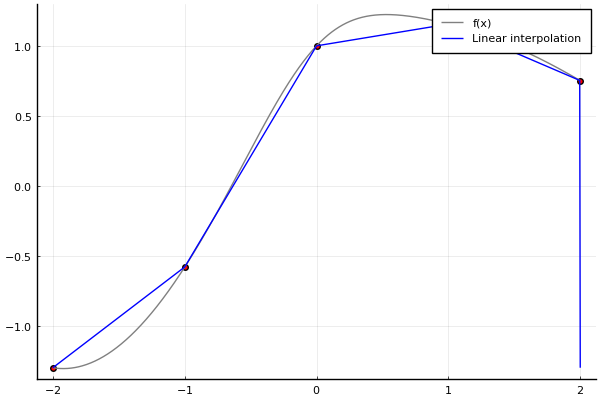

In [5]:
f(x) = exp(-x/4) * sin(x) +1/(1+x^2)
m=5; a=-2; b=2;

x0 = LinRange(a,b,m)

fx0 = f.(x0)
fhat = LinearInterpolation(x0,fx0,extrapolation_bc=Periodic())
sieve.plot1d(f=f,x0=x0,fx0=fx0,fhat=fhat,label="Linear interpolation")



### Approaches

1. *Piece-wise* approach (connect the dots)  
    - Which functional form to use for connections?
    - Simple lienar interpolation and splines are examples of this approach
    - What are advantages and disadvantages? 


1. Use a *similar* function $s(x)$ to represent $ f(x) $
  between the data points  
    - Which simpler function?  
    - Example: $s(x)$ could be a polynomial 
    - What data should be used?  
    - How to control the accuracy of the approximation? 

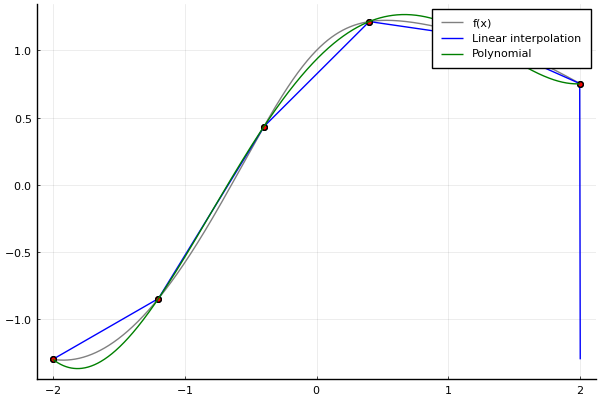

In [6]:

m=6; a=-2; b=2;

x0 = LinRange(a,b,m)

fx0 = f.(x0)

fhat = LinearInterpolation(x0,fx0,extrapolation_bc=Periodic())

p1 = sieve.plot1d(f=f,x0=x0,fx0=fx0,fhat=fhat,label="Linear interpolation")
p = fit(x0,fx0,m-1) # From poynomials
p2 = sieve.plot1d(p=p1,x0= x0,fx0= fx0, fhat=p, label="Polynomial", color=:green)


### Sieve approximation
- **An example a local piecewise approach** is to approximate $f(x)$ by a stepwise flat function. 
- This would involve dividing the interval $[a,b]=[x_0,x_{n+1}]$ in to $n+1$ subintervals $ [x_j,x_{j+1}] $, $ j=0,\dots,n$ and approximate $f(x)$ by
    $$f(x) \approx \sum_{j=0}^{n} \alpha_j \mathbb{1}(x_j\le x < x_{j+1}) $$

- **An example of a more smooth approach** is to approximate $f(x)$ (simple algebraic) polynomial of degree $n$ so that 
    $$f(x) \approx p_n(x,\alpha)=\alpha_0 + \alpha_1 x + \alpha_2 x^2 \dots + \alpha_n x^n = \sum_{j=0}^n \alpha_j x^j $$
    
- Both approaches are really a special case of the same class of function, **linear sieves**
- Linear sieves are essentially linear functions with  $n+1$ parameters and corresponding basis functions $\{B_i(x)\}_{i=0}^{n}$ such that
 $$f(x) \approx s(x,\alpha)= \sum_{j=0}^{n} \alpha_j B_j(x) $$
 where $B_j(x)=\mathbb{1}(x_j\le x < x_{j+1}) $ for the step-function and $B_j(x)=x^j$ for a simple algebraic polynomial
   

### How do we approximate $f(x)$ by the sieve $s(x,\alpha)$

Suppose that: 
- We have access to a "data set" $ \{(x_i,f(x_i)\}, i=1,\dots,m$  
- We know the functional form of the $n+1$ basis functions $\{B_i(x)\}_{i=0}^{n}$. For example $B_j(x)=x^j$ in case of simple polynomials

- In the case of a linear sieve we can easily "estimate" $\alpha=\alpha_0,\dots,\alpha_{m-1}$   using linear regression based on a set of $m\ge n+1$ grid points on x and f(x). 

$$ \hat{\alpha} = \arg \min_{\alpha \in \mathbb{R}^n} \sum_{i=1}^{m} \left[f(x_i)-\sum_{j=0}^{n} \alpha_j B_j(x_i) \right]^2
$$

### Can we approximate f(x)?
Can we find $\alpha$? 
- Yes, if we have $m \ge n+1$ data points and $x_i$ are distinct such that $B_i(x_i)$ are not co-linear, all $n+1$ elements in the vector of sieve coefficients $\alpha$ are uniquely identified. 
- Good old OLS $\alpha=\left(B(x)'B(x)\right)^{-1}B(x)'f(x)$


Can we deal with with high order polynomials if x is large? 
- Yes, change of variable from $x\in [a,b]$ to $z\in [-1,1]$. 

Can we approximate f(x). 
- Yes, at least in the nodes (perfectly if $m=n+1$). 
- Before we formally study the theoretical properties, let's just try

In [7]:
m = 4 ; deg = 3; a = -5; b=50; btype ="algpol" ; gridtype="u"; nknots=10;
n = 5
k = length(n)


1

In [8]:
Array{Float64}(undef,2)
fill(2,1)

1-element Vector{Int64}:
 2

In [9]:
x = Array([1])

1-element Vector{Int64}:
 1

In [10]:
deg = Array([5]) .-1 

1-element Vector{Int64}:
 4

In [11]:
maximum(deg)

4

### Distinction for function approximation: interpolation and curve fitting

- **Interpolation** refers to the situations when **data** on function values is matched **exactly**  
  - The approximation curve passes through the points of the data
  - If parameters of approximating function is "estimated" parameters are *exactly-identified* 
- **Curve fitting** refers to the statistical problem when the data has
  **noise**, the task is to find an approximation for the central
  tendency in the data  
  - Linear and non-linear regression models, econometrics  
  - The model is *over-identified* (there is more data than needed to
    exactly identify the regression function) 
  - For approximations of functions, there is not really noise in our data. However, when the basis does not span the full functional space that $f(x)$ belongs to we will not be able to match all the points and we use ideas similar curve fitting (often linear regression).

### Does sieve $s(x;\alpha)$ converge to $f(x)$ when there are more points and/or basis functions?
- This depends on the function and the choice of basis functions. Let's first focus on polynomials!

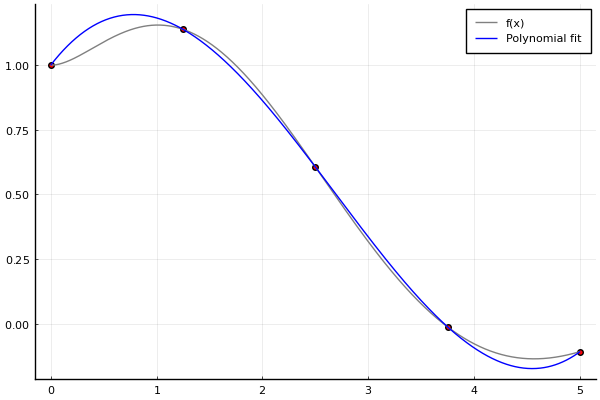

In [33]:
function f(x)
    exp(-x/4)*sin(x) +1 /(1+x)
end

a = 0.01; b=5;n= 5; deg=4

x0   = LinRange(0,5,n)
fx0  = f.(x0)
fhat = fit(x0,fx0,deg) # From poynomials

p1 = sieve.plot1d(f=f,x0=x0,fx0=fx0,fhat =fhat,label="Polynomial fit") #,label="Linear interpolation"

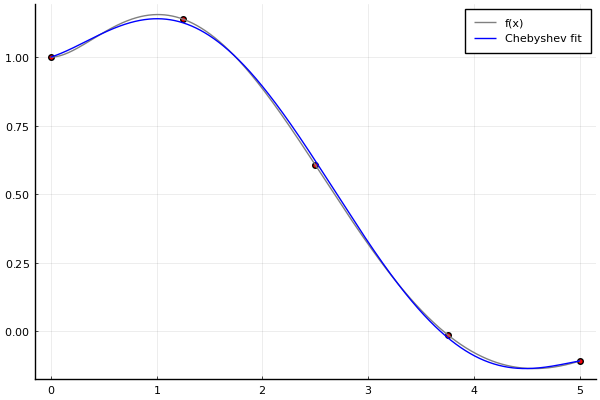

In [77]:
points = chebpoints(n,0.,5.)
c = chebinterp(f.(points),0.,5.)

# Alternatively 
# using BasicInterpolators: ChebyshevInterpolator
#c = ChebyshevInterpolator(f,0,5,n+1)

p1 = sieve.plot1d(f=f,x0=x0,fx0=fx0,fhat =c,label="Chebyshev fit") #,label="Linear interpolation"

In [57]:
p

5×5 Matrix{Float64}:
 1.0  4.87764   46.5828    449.55      4338.91
 1.0  3.96946   30.5133    238.273     1861.12
 1.0  2.5       11.5        55.0        263.5
 1.0  1.03054    1.12401     1.28614      1.52681
 1.0  0.122359  -0.970057   -0.359748     0.88202

In [ ]:
f= lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2)    # function to interpolate/approximate
#f = lambda x: (np.log(x*2/3)+0.5*np.log(x*1/3))    # another function to approximate (only for x>0)
a=0.01; b=5; n=5; deg=4;
sa=sieve(n, deg, a, b, btype='algpol', gridtype='u');    sa.plot1d(f); plt.show() # basis: (ordinary) Algrbraic polynomials
sc=sieve(n, deg, a, b, btype='chebyshev', gridtype='c'); sc.plot1d(f); plt.show() # basis: Chebyshev polynomials

### Least squares approximation

We could also go back to **function approximation** and fit polynomials
of lower degree

- Data set $ \{(x_i,f(x_i)\}, i=1,\dots,m $  
- **Any** functional form $ g(x) $ from class $ G $ that best
  approximates $ f(x) $  


$$
g = \arg\min_{g \in G} \lVert f-g \rVert ^2
$$

### Orthogonal polynomial approximation/interpolation

- Polynomials over domain $ D $  
- Weighting function $ w(x)>0 $  


Inner product

$$
\langle f,g \rangle = \int_D f(x)g(x)w(x)dx
$$

$ \{\phi_i\} $ is a family of orthogonal polynomials w.r.t.
$ w(x) $ iff

$$
\langle \phi_i,\phi_j \rangle = 0, i\ne j
$$

#### Best polynomial approximation in L2-norm

Let $ \mathcal{P}_n $ denote the space of all polynomials of degree $ n $ over $ D $

$$
\lVert f - p \rVert_2 = \inf_{q \in \mathcal{P}_n} \lVert f - q \rVert_2
= \inf_{q \in \mathcal{P}_n}  \left[ \int_D ( f(x)-g(x) )^2 dx  \right]^{\tfrac{1}{2}}
$$

if and only if

$$
\langle f-p,q \rangle = 0, \text{ for all } q \in \mathcal{P}_n
$$

*Orthogonal projection is the best approximating polynomial in L2-norm*

#### Uniform (infinity, sup-) norm

$$
\lVert f(x) - g(x) \rVert_{\infty} = \sup_{x \in D} | f(x) - g(x) |
= \lim_{n \rightarrow \infty} \left[ \int_D ( f(x)-g(x) )^n dx  \right]^{\tfrac{1}{n}}
$$

Measures the absolute difference over the whole domain $ D $

#### Chebyshev (minmax) approximation

What is the best polynomial approximation in the uniform (infinity, sup) norm?

$$
\lVert f - p \rVert_{\infty} = \inf_{q \in \mathcal{P}_n} \lVert f - q \rVert_{\infty}
= \inf_{q \in \mathcal{P}_n}  \sup_{x \in D} | f(x) - g(x) |
$$

Chebyshev proved existence and uniqueness of the best approximating polynomial in uniform norm.

#### Chebyshev polynomials

- $ [a,b] = [-1,1] $ and $ w(x)=(1-x^2)^{(-1/2)} $  
- $ T_n(x)=\cos\big(n\cos^{-1}(x)\big) $  

- Recursive formulas:  
$$
\begin{eqnarray}
T_0(x)=1,\\
T_1(x)=x,\\
T_{n+1}(x)=2x T_n(x) - T_{n-1}(x)
\end{eqnarray}
$$


- Chebyshev polynomials are mutually orthogonal wrt to the weighting function $w(x)=(1-x^2)^{(-1/2)}$ 

- If we approximate f(x) by Chebyshev-least squares, we put equal weight on where we want to minimize the squared error. 
- The leading term in the maximum error of a $n-1$ degree interpolation is $T_n(x)$
- If we want to achieve the best set of interpolation nodes that minimizes the maximum error bound for a degree $n-1$ interpolation, the interpolation nodes $x_1,\dots, x_n$ must be the zeros of $T_n(x)$
$$x_k=cos\left( \frac{2k-1}{2n}\pi\right), \quad \quad, k=1,\dots,n$$

### Let's compare basis for Chebyshev and Algebraic polynomials  

In [ ]:
n=4
# plot nodes
x0,z0 =sieve.grid(n=n, a=0, b=1, gridtype='c') # chebyshev nodes are roots of n-degree chebyshev polynomials
plt.figure(figsize=(10,8))
plt.scatter(z0, z0*0)

# plot Chebyshev polynomials up to degree n
z=np.linspace(-1,1,100).reshape(-1,1)
B=sieve.basis_j(z, deg=n, btype='chebyshev') 
#B=sieve.basis(z, deg=[n], btype=['algpol']) # Try this and increase degree
plt.plot(z, B[:,:-1], linewidth=1)
plt.plot(z, B[:,-1], linewidth=3)
plt.show()


### Are Chebyshev and Algebraic polynomials orthogonal

In [ ]:
n=10;deg=n-1; 
sa=sieve(n, deg, a, b, btype='algpol', gridtype='u');    # basis: (ordinary) Algrbraic polynomials
sc=sieve(n, deg, a, b, btype='chebyshev', gridtype='c'); # basis: Chebyshev polynomials
print('Algebraic polynomials')
disp(sa.B.T@sa.B)
print('Chebyshev polynmials')
disp(sc.B.T@sc.B)


#### General interval

- Not hard to adapt the polynomials for the general interval
  $ [a,b] $ through linear change of variable  


$$
y = 2\frac{x-a}{b-a}-1
$$

- Orthogonality holds with weights function with the same change of
  variable  

#### Chebyshev approximation algorithm

1. Given $ f(x) $ and $ [a,b] $  
1. Compute Chebyshev interpolation nodes on $ [-1,1] $  
1. Adjust nodes to $ [a,b] $ by change of variable, $ x_i $  
1. Evaluate $ f $ at the nodes, $ f(x_i) $  
1. Compute Chebyshev coefficients $ a_i = g\big(f(x_i)\big) $  
1. Arrive at approximation  


$$
f(x) = \sum_{i=0}^n a_i T_i(x)
$$

#### Accuracy of Chebyshev interpolation

Suppose $ f: [-1,1]\rightarrow R $ is $ C^k $ function for some
$ k\ge 1 $, and let $ I_n $ be the degree $ n $ polynomial
interpolation of $ f $ with nodes at zeros of $ T_{n+1}(x) $.
Then

$$
\lVert f - I_n \rVert_{\infty} \le \left( \frac{2}{\pi} \log(n+1) +1 \right) \frac{(n-k)!}{n!}\left(\frac{\pi}{2}\right)^k \lVert f^{(k)}\rVert_{\infty}
$$

📖 Judd (1988) Numerical Methods in Economics

- achieves *best polynomial approximation in uniform norm*  
- works for smooth functions
- easy to compute  
- but *does not* approximate $ f'(x) $ well  

### Limits to polynomial interpolation/approximation 

In [ ]:
f1 = lambda x: np.minimum(np.maximum(4*(x-0.2),-1),1)   # function to approximate (for a=-1,b=1)
#f1= lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2)       # function to interpolate/approximate (smooth on small intervals)
f2 = lambda x: np.log(x)                               # function to approximate (only for x>0)
deg=10; n=deg+1;    # Try increasing degree and number of nodes
btype='chebyshev'; gridtype='c'; # 
# btype='algpol'; gridtype='u'; # Try algpol
s1=sieve(n, deg, a=-2, b=2,   btype=btype, gridtype=gridtype);  
s2=sieve(n, deg, a=0.00001, b=10, btype=btype, gridtype=gridtype);  
s1.plot1d(f1); plt.show() # basis: Chebyshev polynomials 
s2.plot1d(f2); plt.show() # basis: (ordinary) Algrbraic polynomials

### Transformation

In [ ]:
deg=5; n=deg+1;    # Try increasing degree and number of nodes
f1 = lambda x: np.log(x)  # function to approximate (only for x>0)
β=0.5; V= lambda x: np.log(x)/(1-β) + np.log(1-β)/(1-β) + β *np.log(β)/((1-β)**2)
f1 = V # Value function for cake eating problem
btype='chebyshev'; gridtype='c'; # btype='algpol'; gridtype='u'; 
s=sieve(n, deg, a=0.00001, b=1, btype=btype, gridtype=gridtype);  
s_tr=sieve(n, deg, a=0.00001, b=10, btype=btype, gridtype=gridtype, \
           transform=lambda x: np.exp(x), inv_transform=lambda x: np.log(np.maximum(x, 1e-20)));  
s.plot1d(f1); plt.show() # basis: Chebyshev polynomials 
s_tr.plot1d(f1, label='Transformed'); plt.show() # basis: (ordinary) Algrbraic polynomials

### Extrapolation

Extrapolation is computing the approximated function outside of the
original data interval

**Should be avoided in general**

- Exact *only* when theoretical properties of the extrapolated function
  are known  
- Can be used with extreme caution and based on the analysis of the model  
- Always try to introduce wider bounds for the grid instead  

**NEVER extrapolate high degree polynomials.**: Nodes a like hands that tries to fix a wild snake. 

In [ ]:
m=5; a=0; b=5; extrapolate=5            # try increasing m (does linear gets worse, does polynmial)               
x0 = np.linspace(a,b,m);                 # x0:  grid points where we know f(x)
x1 =  np.linspace(a,b+extrapolate,100);            # x1:  extended grid points for extrapolation
f= lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2)       # function to interpolate/approximate (smooth on small intervals)
fhat = interpolate.interp1d(x0,f(x0), bounds_error=False, fill_value='extrapolate')    # returns the interpolation function
plot1d(None, x0, f(x0)) # use the the plotting tool
plot1d(f, x1, None, fhat, label='Linear Extrapolation') # use the the plotting tool

α = polynomial.polyfit(x0,f(x0),m-1)     # returns polynomial coeficients
fhat = lambda x: polynomial.polyval(x,α)
plot1d(None, x1, None, fhat, label='Polynomial extrapolation', color='g') # use the the plotting tool
    

### Spline interpolation

Spline = curve composed of independent pieces

**Definition** A function $ s(x) $ on $ [a,b] $ is a spline of
order $ n $ ( = degree $ n-1 $) iff

- $ s $ is $ C^{n-2} $ on $ [a,b] $ (has continuous derivatives
  up to order $ n-2 $),  
- given *knot* points $ a=x_0<x_1<\dots<x_m=b $, $ s(x) $ is a
  polynomial of degree $ n-1 $ on each subinterval
  $ [x_i,x_{i+1}] $, $ i=0,\dots,m-1 $  

#### Cubic splines = spline of order 4

- Data set $ \{(x_i,f(x_i), i=0,\dots,n\} $  
- Functional form $ s(x) = a_i + b_i x + c_i x^2 + d_i x^3 $ on
  $ [x_{i-1},x_i] $ for $ i=1,\dots,n $  
- $ 4n $ unknown coefficients:  
- $ 2n $ equations to make sure each segment passes through its interval points +
  $ 2(n-1) $ equations to ensure two continuous derivatives at each interior point  
- Additional 2 equation for the $ x_0 $ and $ x_n $  
  - $ s''(x_0)=s''(x_n)=0 $ (natural spline)  
  - $ s'(x_0)=\frac{s(x_1)-s(x_0)}{x_1-x_0} $,
    $ s'(x_n)=\frac{s(x_n)-s(x_{n-1})}{x_n-x_{n-1}} $
    (secant-Hermite)  

### B-splines
- B-splines play the role of basis functions for the spline function space, hence the name. 
- Expressions for the polynomial (all of same degree k) pieces can be derived by means of the Cox–de Boor recursion formula
$$ B_{i,0}(x):={\begin{cases}1&{\text{if }}t_{i}\leq x<t_{i+1},\\0&{\text{otherwise}}.\end{cases}}$$

$$B_{i,k}(x):={\frac {x-t_{i}}{t_{i+k}-t_{i}}}B_{i,k-1}(x)+{\frac {t_{i+k+1}-x}{t_{i+k+1}-t_{i+1}}}B_{i+1,k-1}(x).$$
- That is, $B_{j,0}(x)$ is piecewise constant one or zero indicating which knot span $x$ is in (zero if knot span j is repeated). 
- The recursion equation is in two parts, where
$${\frac {x-t_{i}}{t_{i+k}-t_{i}}}$$
ramps from zero to one as $x$ goes from $t_{i}$ to $t_{i+k}$, and $${\frac {t_{i+k+1}-x}{t_{i+k+1}-t_{i+1}}}$$ ramps from one to zero as x goes from 
$t_{i+1}$ to $t_{i+k+1}$. 

### B-splines  - basis functions

In [ ]:
k=1                          # polynomial degree, (order of spline - 1) 
nknots=10                      # number of internal knots
a=0; b=100;                    # min and max
knots=np.linspace(a,b,nknots)  # internal knots
x=np.linspace(a,b,1000)        # evaluation point for plotting
B=sieve.basis_j(x, deg=k, btype='b-spline', knots=knots) 
plt.figure(figsize=(10,8))
plt.scatter(knots, knots*0)
plt.plot(x, B, linewidth=3)
plt.title('B-Splines of degree %d based on %d internal knots'% (k,nknots))
plt.show()

### B-splines versus Chebyshev 

In [ ]:
a=-10; b=10; f = lambda x: np.minimum(np.maximum(4*(x-0.2),-1),1)  # "kinky" function 
#a=-1; b=1; f = lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2)         # smooth function 
n=15; 
sb=sieve(n, 2, a, b, btype='b-spline', gridtype='u', nknots=None);      sb.plot1d(f); plt.show() # basis: B-spline
sc=sieve(n, n-1, a, b, btype='chebyshev', gridtype='c');   sc.plot1d(f); plt.show() # basis: Chebyshev polynomials

### Multidimensional interpolation/approximation

- there are multidimensional generalization to all methods based on sieves  
- We consider a tensor product basis: curse of dimensionality in the number of interpolation points when number of dimensions increase  

**Generally much harder!**

### We can do it: Let's try a tensor product basis of Chebyshev polynomials

In [ ]:
f1 = lambda x: np.sin(np.sum(x, axis=1)).reshape(-1,1)           # smooth function with some nonlinear interaction
f1 = lambda x: np.sum(np.sin(2*x), axis=1).reshape(-1,1)         # additively seperable smooth function
#f1 = lambda x: np.log(np.sum(np.abs(x), axis=1)).reshape(-1,1)  # nasty fuction
s1=sieve(n=[11, 11], a=-1, b=2, btype='chebyshev', gridtype='c') # sieve setup
fx=f1(s1.x)        # y-data at nodes s1.x
α = s1.fit(fx)     # sieve coeficients             

neval=[50,50]      # evaluation of function and interpolant on finer grid  
x, z=sieve.grid(n=neval, a=s1.a, b=s1.b, gridtype='u')
fhat=s1.eval(x, α)

# plotting
fig=plot2d(x,f1(x), neval, i=1)
fig=plot2d(x,fhat, neval, fig=fig, i=2, label='Interpolation')
fig=plot2d(x,fhat-f1(x), neval, fig=fig, i=3, label='Approximation error')

### Approximation in $R^d$
Recall our sieve approximation in the 1-dimensional case
$$f(x) \approx s(x,\alpha)= \sum_{j=0}^{n} \alpha_j B_j(x) $$
where 
- $B_j(x)=B_{j,k}(x)$ for the B-Spline of degree $k$ for interval $j$ (sorry for using same notation for B splines and Basis functions)
- $B_j(x)=B_{j,0}(x)=\mathbb{1}(x_j\le x < x_{j+1}) $ the step-function (B-spline of degree 0 for interval j)
- $B_j(x)=x^j$ for a simple algebraic polynomial of degree $j$ 
- $B_j(x)=T_j(x)$ for Chebyshev polynomials of degree $j$

This formula can be directly generalized to d dimensions:
$$f(x_1,\dots,x_d) \approx s(x_1,\dots,x_d,\alpha)=  \sum_{i_1=0}^{n_1} \dots \sum_{i_d=0}^{n_d}  \alpha_{i_1\dots 
i_d} \prod_{k=1}^d B_{i_k}(x_{k})$$
For d=2 we have
$$f(x_1,x_2) \approx s(x_1,x_2,\alpha)=  \sum_{i_1=0}^{n_1} \sum_{i_2=0}^{n_2}  \alpha_{i_1,
i_2} d B_{i_1}(x_{1}) B_{i_2}(x_{2})$$

### Looks nasty, but is quite easy with matrix notation
$$f(x_1,\dots,x_d)=\mathbf{B(x)}\alpha$$ 
where 
- $\mathbf{B(x)}$ is the matrix with as many rows as we have grid-points and as many columns as we cam make combinations of basis functions across the $d$ dimensions d with $n_d+1$ basis functions in each dimension. 
- $\mathbf{B(x)}$ has $\prod_{k=1}^d (n_d+1)$ columns.
- $\alpha$ is a vector of coefficients with $\prod_{k=1}^d (n_d+1)$ rows
- To identify all coefficients we need at least $\prod_{k=1}^d (n_d+1)$ DISTRICT points on our grid. We can this as the so called Cartesian grid that gives all combinations of gridpoints used in dimensions $k=1,\dots,d$

### .... and even easier in Python. Let's first do the Cartesian grid

In [ ]:
def cartesian(x):
    d=len(x)
    return np.array(np.meshgrid(*x)).T.reshape(-1,d)

x1=np.linspace(1,2,2); x2=np.linspace(3,5,3);  x=[x1, x2]; 
X=cartesian(x)
print('x1=', x1)
print('x2=', x2)
print('X', X.shape)
disp(X)


### .... and and now the d fold tensor product basis

In [ ]:
def tensor(b): 
    '''k-fold tensor product list of matrices b=[b[0],b[1],...,b[k-1]]'''
    T=b[0]   # Initialize Tensor product basis with first element in b 
    for j in range(len(b)-1): # loop over remainng dimensions in b
        T=(T[:,:,None]*b[j+1][:,None,:]).reshape(T.shape[0],-1)  # use boradcasting
    return T

B1=sieve.basis_j(X[:,0], deg=2, btype='algpol')
B2=sieve.basis_j(X[:,1], deg=2, btype='algpol')

print('B1'); disp(B1)
print('B2'); disp(B2)

T=tensor([B1,B2])
print('T', T.shape); disp(T)

### Before we look at coefficients let's consider our 2-d Chebyshev approximation from before

In [ ]:
f1 = lambda x: np.sin(np.sum(x, axis=1)).reshape(-1,1)           # smooth function with some nonlinear interaction
f1 = lambda x: np.sum(np.sin(2*x), axis=1).reshape(-1,1)         # additively seperable smooth function
#f1 = lambda x: np.log(np.sum(np.abs(x), axis=1)).reshape(-1,1)  # nasty fuction
s1=sieve(n=[11, 11], a=-1, b=2, btype='chebyshev', gridtype='c') # sieve setup
fx=f1(s1.x)        # y-data at nodes s1.x
α = s1.fit(fx)     # sieve coeficients             

neval=[50,50]      # evaluation of function and interpolant on finer grid  
x, z=sieve.grid(n=neval, a=s1.a, b=s1.b, gridtype='u')
fhat=s1.eval(x, α)

# plotting
fig=plot2d(x,f1(x), neval, i=1)
fig=plot2d(x,fhat, neval, fig=fig, i=2, label='Interpolation')
fig=plot2d(x,fhat-f1(x), neval, fig=fig, i=3, label='Approximation error')

### How does the coefficients look like?  

In [ ]:
print('Transposed coefficients')
disp(α.reshape(s1.deg[0]+1,s1.deg[1]+1))

### Let's try a tensor product basis of B-splines

In [ ]:
f1 = lambda x: np.sin(np.sum(x, axis=1)).reshape(-1,1)           # smooth function with some nonlinear interaction
f1 = lambda x: np.sum(np.sin(2*x), axis=1).reshape(-1,1)         # additively seperable smooth function
#f1 = lambda x: np.log(np.sum(np.abs(x), axis=1)).reshape(-1,1)  # nasty fuction
s1=sieve(n=[11, 11], deg=[3], a=-1, b=2, btype=['b-spline'], gridtype=['u']) # sieve setup - try different defgrees
#s1=sieve(n=[11, 11], deg=[3,10], a=-1, b=2, btype=['b-spline','chebyshev'], gridtype=['u','c']) # sieve setup - try different defgrees
fx=f1(s1.x)        # y-data at nodes s1.x
α = s1.fit(fx)     # sieve coeficients             

neval=[50,50]      # evaluation of function and interpolant on finer grid  
x, z=sieve.grid(n=neval, a=s1.a, b=s1.b, gridtype='u')
fhat=s1.eval(x, α)

# plotting
fig=plot2d(x,f1(x), neval, i=1)
fig=plot2d(x,fhat, neval, fig=fig, i=2, label='Interpolation')
fig=plot2d(x,fhat-f1(x), neval, fig=fig, i=3, label='Approximation error')

### Coefficients for Spline approximation is dense

In [ ]:
print('Transposed coefficients')
disp(α.reshape(s1.nknots[0]+2,s1.nknots[1]+2))
     

### Curse of dimensionality
- It may be easy to program, but the tensor product basis i subject to **CURSE OF DIMENSIONALITY**. 
- The number of basis functions, corresponding coefficients and required nodes are all exponentially increasing in $d$
- Sparse Smolyak grids and adaptive sparse grids  
- Do we need the regular Cartesian grid
    - Perhaps randomization can break the curse of dimensionality
    - Irregular grids require computationally expensive triangulation in the general case
    - Good application for machine learning!  

### Further learning resources

- [https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)  
- [https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html)  
- M.H. Mudde’s thesis on Chebyshev approximation [http://fse.studenttheses.ub.rug.nl/15406/1/Marieke_Mudde_2017_EC.pdf](http://fse.studenttheses.ub.rug.nl/15406/1/Marieke_Mudde_2017_EC.pdf)  

# Some calls and illustrations using build in Python routines in 1d


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2008) # fix random number sequences
x  = np.sort(np.random.uniform(-5,10,12)) # sorted random numbers on [-5,10]
xr = np.linspace(-5,10,12) # regular grid on [-5,10]

func=lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2) # function to interpolate

In [ ]:
def plot1(ifunc,fdata=(x,func(x)),f=func,color='b',label='',extrapolation=False):
    '''helper function to make plots'''
    xd = np.linspace(-5,10,1000) # for making continuous lines
    plt.figure(num=1, figsize=(10,8))
    plt.scatter(fdata[0],fdata[1],color='r') # interpolation data
    plt.plot(xd,f(xd),color='grey') # true function
    if extrapolation:
        xdi = xd
    else:
        # restriction for interpolation only
        xdi=xd[np.logical_and(xd>=fdata[0][0],xd<=fdata[0][-1])]
    if ifunc:
        plt.plot(xdi,ifunc(xdi),color=color,label=label)
        if label:
            plt.legend()
    elif label:
        plt.title(label)

In [ ]:
from scipy import interpolate # Interpolation routines
fhat = interpolate.interp1d(x,f(x)) # returns the interpolation function
plot1d(f, x, f(x), fhat,label='interp1d')

In [ ]:
help(interpolate.interp1d)

In [ ]:
fhat = interpolate.interp1d(x,f(x),kind='linear')
plot1d(f, x, f(x), fhat,label='Linear')

In [ ]:
plot1d(f, x, f(x))
for knd, clr in ('previous','m'),('next','b'),('nearest','g'):
    fhat = interpolate.interp1d(x,func(x),kind=knd)
    plot1d(x0=x, fhat=fhat, label=knd,color=clr)
plt.show()

In [ ]:
for knd, clr in ('slinear','m'),('quadratic','b'),('cubic','g'):
    fi = interpolate.interp1d(x,f(x),kind=knd)
    plot1(fi,color=clr,label=knd)

In [ ]:
# Approximation errors
x = np.sort(np.random.uniform(-5,10,11))  # generate new data
for knd, clr in ('slinear','m'),('quadratic','b'),('cubic','g'):
    fi = interpolate.interp1d(x,func(x),kind=knd,bounds_error=False)
    xd = np.linspace(-5,10,1000)
    erd=np.abs(func(xd)-fi(xd))
    plt.plot(xd,erd,color=clr)
    print('Max error with  %s splines is %1.5e'%(knd,np.nanmax(erd)))

In [ ]:
# Approximation errors for regular grid
for knd, clr in ('slinear','m'),('quadratic','b'),('cubic','g'):
    fi = interpolate.interp1d(xr,func(xr),kind=knd,bounds_error=False)
    xd = np.linspace(-5,10,1000)
    erd=np.abs(func(xd)-fi(xd))
    plt.plot(xd,erd,color=clr)
    print('Max error with  %s splines is %1.5e'%(knd,np.nanmax(erd)))

#### Accuracy of the interpolation

How to reduce approximation errors?

- Number of nodes (more is better)  
- Location of nodes (regular is better)  
- Interpolation type (match function of interest)  


*In economic models we usually can control all of these*

In [ ]:
from numpy.polynomial import polynomial
degree = len(x)-1 # passing through all dots
p = polynomial.polyfit(x,func(x),degree)
fi = lambda x: polynomial.polyval(x,p)
plot1(fi,label='Polynomial of degree %d'%degree,extrapolation=True)

In [ ]:
# now with regular grid
degree = len(xr)-1 # passing through all dots
p = polynomial.polyfit(xr,func(xr),degree)
print(p.shape)
fi = lambda x: polynomial.polyval(x,p)
plot1(fi,fdata=(xr,func(xr)),label='Polynomial of degree %d'%degree,extrapolation=True)

In [ ]:
# how number of points affect the approximation (with degree=n-1)
for n, clr in (5,'m'),(10,'b'),(15,'g'),(25,'r'):
    x2 = np.linspace(-5,10,n)
    p = polynomial.polyfit(x2,func(x2),n-1)
    fi = lambda x: polynomial.polyval(x,p)
    plot1(fi,fdata=(x2,func(x2)),label='%d points'%n,color=clr,extrapolation=True)
    plt.show()

In [ ]:
# how locations of points affect the approximation (with degree=n-1)
np.random.seed(2025)
n=8
for clr in 'b','g','c':
    x2 = np.linspace(-4,9,n) + np.random.uniform(-1,1,n) # perturb points a little
    p = polynomial.polyfit(x2,func(x2),n-1)
    fi = lambda x: polynomial.polyval(x,p)
    plot1(fi,fdata=(x2,func(x2)),label='%d points'%n,color=clr,extrapolation=True)
    plt.show()

In [ ]:
# how degree of the polynomial affects the approximation
for degree, clr in (7,'b'),(9,'g'),(11,'m'):
    p=polynomial.polyfit(xr,func(xr),degree)
    fi=lambda x: polynomial.polyval(x,p)
    plot1(fi,fdata=(xr,func(xr)),label='Polynomial of degree %d'%degree,color=clr,extrapolation=True)